Adam Peetz<br>
September 25th 2022<br>
MSDS680 Week 5 Assignment<br>
Regis University<br>
Professor Nasheb Ismaily<br>

# Detecting Credit Card Fraud with Neural Networks

The United States saw around $11 billion dollars of losses due to credit card fraud in 2020. That number is expected to increase over time. (Lee, 2021) Consumers can protect themselves by issuing chargebacks for purchases they didn’t make, but this leaves businesses holding the bag for those transactions. Preventing criminals from making fraudulent transactions is the only way to protect those businesses from harm. <br>

Machine learning is one domain that can help reduce the occurrence of credit card fraud by blocking transactions at the point of sale. A machine learning model, trained to identify fraud, could be incorporated into a transaction system to block these purchases at the time they occur. <br>

One of the most powerful learning methods in use today is the neural network. Neural networks use a collection of algorithms to approximate a solution for classification and regression problems through an interconnected series of nodes. A method for detecting fraud with a neural network will be demonstrated in the notebook below. <br>

The dataset for this project comes from a dataset assembled by Caelen et al. (2013) in a collaboration between the MLG of ULB and Worldline. The data itself has already been prepared for machine learning by Caelen et al., who transformed the original features into 28 new ones using a principal component analysis. The dataset will be left in its original condition except for the removal of the 'time' feature. Time is indicated in the metadata as corresponding to the seconds that elapsed between the transaction and the creation of the dataset. This feature should not have any relation to the prediction and will be removed from the dataset.


In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix  

In [2]:
#import dataset
credit_df = pd.read_csv('creditcard.csv', sep=',')

In [3]:
#sample dataset 
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#drop unneeded columns
#time is indicated in the metadata to be a feature that does not correspond to fraud 
credit_df.drop(labels=['Time'], axis=1, inplace=True)

In [5]:
#divide into features and targets
features = credit_df.drop('Class', axis=1)
targets = credit_df['Class']

##break data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2,random_state=1)

# Exploratory Data Analysis

## Class Balance and Null Info Rate

The credit dataset has an extreme class imbalance. 284,807 transactions are recorded, of which only 492 are fraud, representing 0.172% of the data. Graphing the counts of legitimate and fraudulent transactions demonstrates the class imbalance. Since there are so few examples of fraud in this dataset, raw accuracy cannot be used as a metric for evaluating the model. Recall for the prediction of fraud will need to be used as a metric to evaluate how effective the model is at predicting the minority class.


In [6]:
# display lass balance by percentage
credit_df.groupby('Class')['V1'].count().sort_values(ascending=False).head(10)/credit_df.shape[0]

Class
0    0.998273
1    0.001727
Name: V1, dtype: float64

<Figure size 432x288 with 0 Axes>

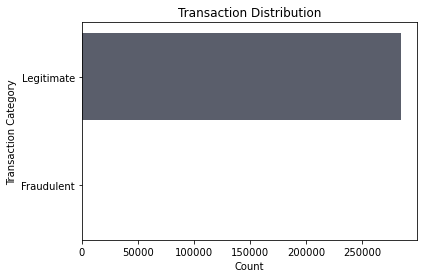

<Figure size 432x288 with 0 Axes>

In [7]:
#group and count, sort for highest value
graph = credit_df.groupby('Class').count()
graph['Class'] = ['Legitimate', 'Fraudulent']
graph.sort_values(by='V1',inplace=True,ascending=False)
sns.barplot(data=graph,x='V1',y='Class',palette='cividis')
plt.ylabel('Transaction Category')
plt.xlabel('Count')
plt.title('Transaction Distribution')

plt.figure()

# Principal Component Analysis

A principal component analysis attempts to express the variability of high dimensional data in a lower dimensional space. Compressing the data to 2 dimensions using PCA and projecting it on a scatterplot can demonstrate how clustered the data is and give an idea of how easy it will be to establish a decision boundary between the classes. The PCA projection, shown below, demonstrates that there is little separation between fraudulent and legitimate transactions. The class imbalance present in the dataset contributes to this overwhelming clustering of grey.


Text(0.5, 1.0, 'Projection of clustering using PCA')

<Figure size 432x288 with 0 Axes>

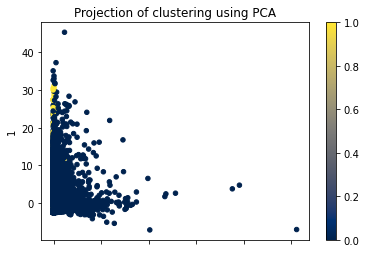

In [8]:
#create PCA object
pca = PCA()
#reduce dimensonality of the features
data_reduced = pca.fit_transform(features)
data_reduced = pd.DataFrame(data_reduced)
#plot chart of PCA results with kmean labels
plt.figure()
ax2 = data_reduced.plot(kind='scatter', x=0, y=1,c=targets, cmap='cividis')
plt.title('Projection of clustering using PCA')


# Correlation Heatmap

A correlation heatmap shows the relationship between variables in the dataset. Most variables show little relationship to each other. Scanning the row for class illustrates the strength of the relationship for certain variables to the prediction target. There is a mix of somewhat correlated and non-correlated variables in this row. Many of the features that show low correlation to the target feature could be dropped from the dataset, however, the process of tuning a neural network with loss should reduce the importance of these features in the model as it trains. Rather than drop these features, they will be left in the dataset and the model will tune them out during the backpropagation of loss.  


<AxesSubplot:>

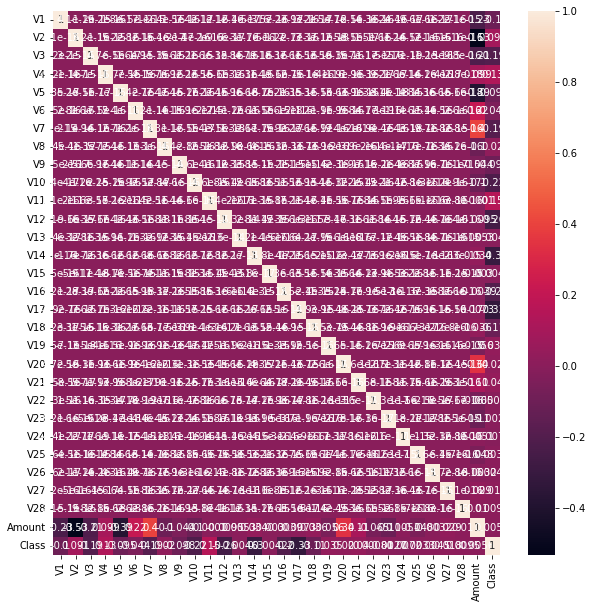

In [9]:
#plot a correlation heatmap
f = plt.figure(figsize=(10, 10))
sns.heatmap(credit_df.corr(), annot=True)

# Baseline with Random Forest (RF)

A random forest algorithm uses an ensemble of decision trees to generate a prediction. A random forest model will be trained and used to predict for credit card fraud to establish an accuracy baseline against which the performance of the following neural networks can be compared. 


In [10]:
#define model, fit model, and generate predictions, metrics

#define model
rfc = RandomForestClassifier(n_jobs = -1, random_state=125)

#fit model to dataset
rfc.fit(X_train, y_train)

#generate predictions
prediction = rfc.predict(X_test)

#generate metrics
print(confusion_matrix(y_test,prediction))  
print(classification_report(y_test, prediction,  digits=4))

[[56870     5]
 [   22    65]]
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56875
           1     0.9286    0.7471    0.8280        87

    accuracy                         0.9995     56962
   macro avg     0.9641    0.8735    0.9139     56962
weighted avg     0.9995    0.9995    0.9995     56962



# Baseline Model Discussion

The baseline RF model achieves a 74% recall score on the dataset for prediction of fraud. It correctly labeled 65 of 87 samples as fraud. Future models will be compared to the RF baseline to judge their ability to predict for fraud in the dataset.


# Solving with a Neural Network (Multi-Layer Perceptron)

Neural networks are also referred to as multi-layer perceptron’s (MLP). Sci-Kit learn includes a MLP model as a part of its machine learning algorithm kit. Several hyperparameters have been adjusted from the default settings to setup the model for a successful prediction.

1. Additional hidden Layers have been created ranging from 256 to 32. This pyramid network shape is a common pattern for neural networks.
2. Max iterations was increased to 10,000 to give the model excessive runway for training.
3. A random_state was implemented to create reproducibility in the model (seed 131 was also a winning ticket, more on that later).
4. Early stopping was set to true. Early stopping is a technique that stops the model's training and returns its best weights if the model has not shown improvement after a certain amount of time. This technique generally returns networks weights that represent the optimum balance between loss and validation scores.

The model is defined, trained, tested, and scored in the cells below. 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.94      0.76      0.84        87

    accuracy                           1.00     56962
   macro avg       0.97      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



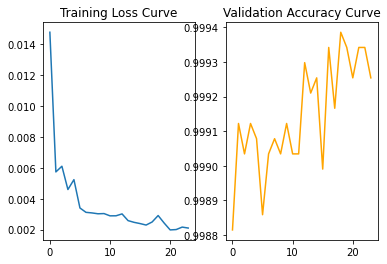

In [11]:
#Define, Train, Test, Score

#Define
mlp = MLPClassifier(hidden_layer_sizes=(256,128,64,32),
                    max_iter=10000, 
                    random_state=131,
                    early_stopping=True,
                   )  

#train
mlp.fit(X_train.values, y_train.values.ravel())  

#plot validation and loss
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2)

#Loss Graph Options
ax1.set_title('Training Loss Curve')
ax1.plot(mlp.loss_curve_)

#Validation Graph options
ax2.set_title('Validation Accuracy Curve')
ax2.plot(mlp.validation_scores_,color='orange')

#test
predictions = mlp.predict(X_test.values)  

#score
print(classification_report(y_test,predictions))

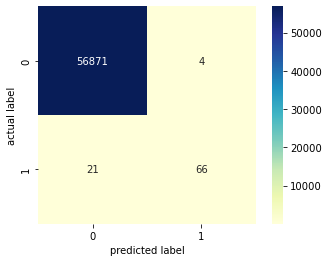

In [12]:
# plot confusion matrix
cm = confusion_matrix(y_test,predictions)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Model Discussion

## Accuracy

The neural network model improved on the recall offered by the random forest model, but it did not beat it by much. In addition to this, it took the neural network model a longer amount of time to train. <br>

Accuracy on test: 100% <br>
<b>Recall on fraud prediction: 76%, a 2% improvement over random forest.</b>
    
## Training Loss and Validation Accuracy Curves

The neural network trained for about 25 epochs before it was stopped by the early stopping hyperparameter. The loss of the model drops significantly for the first 5 epochs before it begins to level off. A loss of 0.003 to 0.002 is recorded for the next 20 epochs, it would have been very difficult to achieve improvements past 0.002 loss where the model stopped.

The accuracy shown by the model reflects the class imbalance in the dataset. The model starts with an accuracy of 99.88%, which is comparable to the null information rate. The model attempts to reach 100% accuracy but has difficult predicting for the minority class which prevents it from reaching perfect prediction on the dataset.

## Confusion Matrix

The confusion matrix shows that the NN model predicted 66 out of 87 fraud labels with the correct label. This performance is comparable to the random forest baseline. The neural network only achieved 1 additional correct prediction of fraud.
    
# Improving the Neural Network's Accuracy

## Under Sampling the Majority Class

There is a class imbalance between fraud and legitimate transactions in the dataset. Training the model on many examples of legitimate transactions and few fraudulent ones biases the weights in the model towards the prediction of legitimate transactions. One way to get around the class imbalance is to under sample the majority class. Under sampling the majority class will increase the importance of minority samples while tuning the weights of the model.
    
The under sampling technique shown in the next cell manually splits the data set into training and holdout sets to avoid data leakage, then under samples the majority class down to a 1 to 1 ratio with the minority class. It is a combination of code adapted from ankthon (2021) and Javier (2019). 


In [13]:
#Undersampling the majority class

#https://www.kaggle.com/code/jdelamorena/recall-97-by-using-undersampling-neural-network/notebook
#https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/

# Creating a dataframe with 80% of values of original dataframe
undersample_df = credit_df.sample(frac = 0.8,random_state=125)
 
# Creating dataframe with the remaining 20% of values
holdoutset_df = credit_df.drop(undersample_df.index)

# create integer value for number of fraud cases
number_records_fraud = len (undersample_df[undersample_df.Class==1])

# obtain index positions of fraud and legitimate rows 
fraud_indices = np.array (undersample_df[undersample_df.Class==1].index)
normal_indices = np.array (undersample_df[undersample_df.Class==0].index)

# randomly select non-fraudulent index positions equal to number of fraud cases
np.random.seed(2020)
random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False)

# concatenate fraudulent and legitimate index numbers for use assembling a new index count
under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])

# generate new dataframe with undersampled indexes
under_sample_df = credit_df.iloc[under_sample_indices,:]

# create new test split with undersampling
X_undersample = under_sample_df.iloc [:, under_sample_df.columns != 'Class'];
y_undersample = under_sample_df.iloc [:, under_sample_df.columns == 'Class'];

#create holdout set features and targets
holdout_features = holdoutset_df.drop('Class', axis=1)
holdout_targets = holdoutset_df['Class']

# Creating a Deeper Network and Scoring a Winning Ticket 
    
Creating a larger neural network generally improves performance at the cost of training time. To improve the performance of the fraud prediction network, the layers will be doubled at each neuron step size. <br>
    
One theory for why large networks perform well is the Lucky Ticket Hypothesis which was proposed by Frankle and Carbin (2018). The lucky ticket hypothesis states that a significantly large randomly initialized neural network will almost always contain a sub network with neuron weights that make it easy to train for the given task. These sub networks are called "winning tickets". While this hypothesis is designed around networks with hundreds of millions of connections, the idea that some random initializations contain weights that are easier to train can be applied to smaller networks. To generate a network that performs well for the fraud prediction task, a GridSearchCV will be performed that tests many random initializations and returns the "winning ticket" randomization with the highest recall. 


In [ ]:
## try to score a winning ticket
## this iterates though many models to attempt to score a winning ticket and will take a bit of time to run
params = {'random_state': (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,\
                           20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,\
                           35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,\
                           50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,\
                           65,66,67,68,69,70,71,72,73,74,75,76,77,76,79,\
                           80,81,82,83,84,85,86,87,889,90,91,92,93,94,95,\
                           96,97,98,99,100,101,102,103,104,105,106,107,108,\
                           109,110,111,112,113,114,115,116,117,118,119,120,\
                           121,123,124,125,1000,10001,10002,10006,102020,\
                           10344,1213,12123,4144,41423,4414,222,3404,23049,\
                           20394,120293,1203901,24958,204958,24920945,30393,\
                           3039458,233023920,4059585,22029385,33039450,203948,\
                           50598,304958,3049485,3032,4049)}

# Setup model for GridSearch
opt = GridSearchCV(MLPClassifier(hidden_layer_sizes=(256, 256, 128,128, 64, 64, 32, 32), 
                                 max_iter=10000,
                                 early_stopping=True)
                   ,params,scoring='recall')

#fit model to problem
opt.fit(X_undersample.values, y_undersample.values.ravel())

In [ ]:
## display best hyperparameters
opt.best_estimator_

In [ ]:
#Define, Fit, Graph, Test, Metrics

#Define
mlp = MLPClassifier(hidden_layer_sizes=(256, 256, 128,128, 64, 64, 32, 32),
                    max_iter=10000, 
                    random_state=33039450, 
                    early_stopping=True,
                   )  

#Fit
mlp.fit(X_undersample.values, y_undersample.values.ravel())  

#plot validation and loss
fig, ax3 = plt.subplots()
ax3.set_title('Training Loss and Validation Accuracy Curves')
ax3.plot(mlp.loss_curve_, label='Train Loss')
ax3.plot(mlp.validation_scores_, label='Val Accuracy')
ax3.legend()

# make predictions
predictions = mlp.predict(holdout_features.values)  

#print metrics 
print(classification_report(holdout_targets,predictions))

In [ ]:
# plot confusion matrix
cm = confusion_matrix(holdout_targets,predictions)
target_labels = np.unique(holdout_targets)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

# Model Discussion

## Accuracy

The winning ticket model trained on a balanced dataset has worse overall accuracy than previous models, achieving 92% accuracy on test, but it scores much higher recall on predictions of fraud, achieving 93% recall on test. 

Accuracy on test: 92% <br>
<b>Recall on fraud prediction: 93%, a 17% improvement over the original NN model and a 19% improvement over RF</b>

## Training Loss and Validation Accuracy Curve Discussion

The winning ticket network trained for 13 epochs before it was stopped by the early stopping hyperparameter. The loss of the model is much higher than the loss recorded by the first neural network, resting at 0.3. In addition to this, its curve is more linear in its descent towards its stopping point when compared to the first curve, which immediately dropped towards its stopping point.

The validation accuracy shown by the winning ticket model during its training reflects the adjustments made to class imbalance in the dataset. Where the first model started about 99.88% accuracy, the winning ticket model starts predicting around 80% accuracy and jumps to 90% before settling around its final accuracy of 85%. 

## Confusion Matrix

The confusion matrix reveals that the new model was far more likely to predict for fraud than previous models, correctly labeling 96 out of 103 fraud examples in the holdout set. The model was also more likely to categorize legitimate transactions as fraudulent, predicting that 4,622 legitimate transactions were fraud. <br>

# Conclusion

There are tradeoffs between the two neural network models. The original model seldom predicted that a legitimate transaction was fraud. The winning ticket model was better at catching fraud but would reject more legitimate transactions. The tradeoff between prediction tendencies would need to be evaluated by the credit card company to determine which they would like to use. Declining purchases from 4,622 customers making legitimate transactions may have reputational consequences for the credit card company employing the model. If they would prefer a model that lets though 17% more fraudulent transactions, but rarely denies legitimate purchases, they may wish to use the original neural network over the winning ticket model tuned for predictions of fraud.


# References

This notebook was created using a blend of techniques from Regis's MSDS600, MSDS680, and MSDS650 coursework. In addition to this, the reference literature for sci-kit learn, pandas, and seaborn was consulted to construct the code. Code examples were also taken and reworked from several web sources cited below. 

ankthon. (2021). <i> Divide a Pandas DataFrame randomly in a given ratio </i>. Geeks for Geeks. retreived 09/15/2022 from https://www.geeksforgeeks.org/divide-a-pandas-dataframe-randomly-in-a-given-ratio/

Caelen, O., Bontempi, G,. Dal Pozzolo, A., Le Borgne, Y., Carcillo, F., Ziegler,  K. (2013). <i> Credit Card Fraud Detection </i>. The Machine Learning Group of Universite Libre de Bruxelles and Worldline. Retreive 09/15/2022 from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Frankle, Jonathan. & Carbin, Michael. (2018). <i> The Lottery Tickey Hypothesis: Finding Sparse Trainable Neural Networks.</i> ICLR 2019. https://doi.org/10.48550/arXiv.1803.03635

Lee, Nathaniel. (2021). <i> Credit card fraud will increase due to the Covid pandemic, experts warn </i>. CNBC. Retrieved 09/15/2022 from https://www.cnbc.com/2021/01/27/credit-card-fraud-is-on-the-rise-due-to-covid-pandemic.html

Javier. (2019). <i> Recall 97% by using undersampling & Neural Network </i>. kaggle.com. retreived 09/15/2022 from https://www.kaggle.com/code/jdelamorena/recall-97-by-using-undersampling-neural-network/notebook

Pandas Development Team. 2021. <i>Python API reference</i> from pandas.pydata.org https://pandas.pydata.org/docs/reference/index.html

Pedregosa et al. (2011). Scikit-learn: Machine Learning in Python. <i> Journal of Machine Learning Research 12,</i> 2825-2830

Waskom ML (2021). seaborn: statistical data visualization. <i> Journal of Open Source Software 6</i>(60): 3021.a
